# Compare similaries between images

Given an image and optionally class label, we want to find if the state of action is start or end or middle.

It is a regression problem. Or classification problem.
Let's define the correct prediction of start and end as 0 and 1.


## HAA500 dataset

What's good about HAA500 dataset is that the videos only have one repetition of actions. (Nope. Some have multiple reps.)

So we can extract the frames. The first ans last frame is the start of the action. And the end state is somewhere in the middle.

It maybe trickier than I thought. How to make the poses more stable?

Let's start with `burpee`. Since it seems like a easy task.


In [2]:
import os
import os.path as osp
import numpy as np
import cv2
import matplotlib.pyplot as plt


In [3]:
data_dir = '../data/haa500'
train_txt = osp.join(data_dir, 'train-img.txt')
val_txt = osp.join(data_dir, 'val-img.txt')
train_imgs = os.listdir(osp.join(data_dir, 'train-img'))
val_imgs = os.listdir(osp.join(data_dir, 'val-img'))


In [4]:
burpees = [i for i in train_imgs if 'burpee' in i]
print(len(burpees))


150


# Pose


In [5]:
train_pkl = np.load(osp.join(data_dir, 'train.pkl'), allow_pickle=True)
# val_pkl = np.load(osp.join(data_dir, 'val.pkl'))

len(train_pkl)


240

In [6]:
def info(anno):
    for k, v in anno.items():
        print(k, end='\t')
        if type(v) == np.ndarray:
            print(v.shape)
        else:
            print(v)


## Countix pose

In [64]:
from utils.common import *
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = (5, 3)

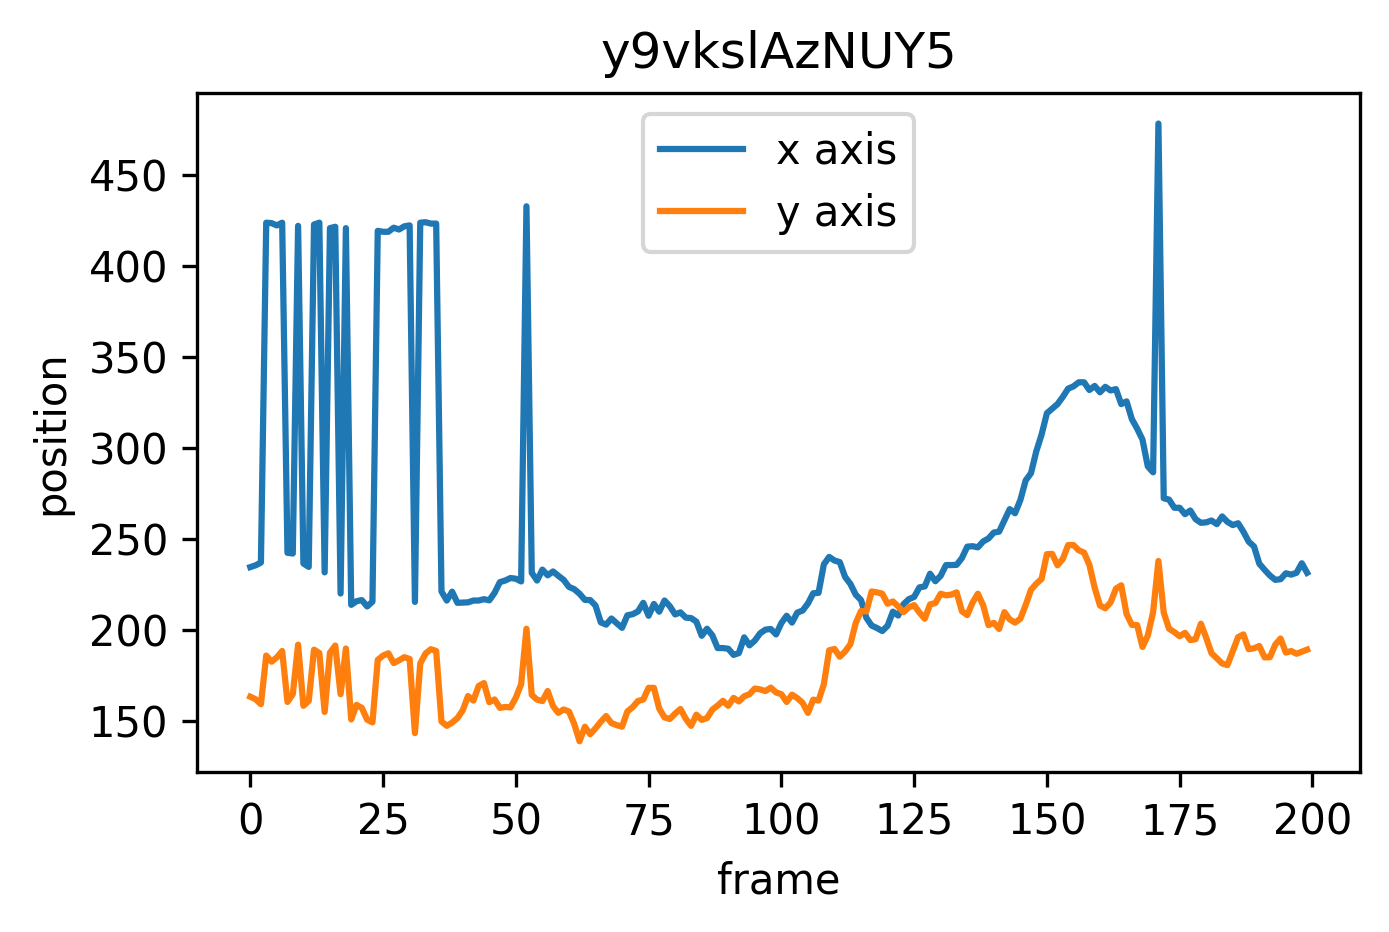

In [65]:
countix = Countix()
countix_anno = countix.get_random_pose()
plot_time_series(countix_anno)

# CNN features

In [9]:

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torchvision import models
from torchvision.io import read_image
from torch.utils.data import DataLoader, Dataset
import sklearn.metrics.pairwise as pw
import gc

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = 'cpu'
data_transforms = {
    'val': T.Compose([
        T.Resize(256),
        T.CenterCrop(224),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

model = models.resnet50(pretrained=True)
list(model.named_modules())[-3:]

[('layer4.2.relu', ReLU(inplace=True)),
 ('avgpool', AdaptiveAvgPool2d(output_size=(1, 1))),
 ('fc', Linear(in_features=2048, out_features=1000, bias=True))]

In [11]:
features = {}
def get_features(name):
    def hook(model, input, output):
        features[name] = output.detach()
    return hook

# feature = model.avgpool.register_forward_hook(lambda m, i, o: print(o.shape))
model.avgpool.register_forward_hook(get_features('avgpool'))
with torch.no_grad():
    inp = torch.randn(1, 3, 224, 224)
    out = model(inp)
print(out.shape)
# print(feature)

torch.Size([1, 1000])


In [12]:
with torch.no_grad():
    inp = torch.randn(1, 3, 224, 224)
    out = model(inp)
print(out.shape)
print(features['avgpool'].reshape(2048))


torch.Size([1, 1000])
tensor([0.3588, 0.5428, 0.4660,  ..., 0.3408, 0.4258, 0.2985])


In [130]:
def get_feats(video_path) -> torch.Tensor:
    print(video_path)
    cap = cv2.VideoCapture(video_path)
    ret, frame = cap.read()
    frames = []
    while ret:
        frame = cv2.resize(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB), (224, 224))
        frames.append(frame)
        ret, frame = cap.read()
    if not frames:
        return
    t = torch.Tensor(frames).permute(0, 3, 1, 2)
    with torch.no_grad():
        model.to(device)
        inp = t.to(device)
        out = model(inp)
    return features['avgpool'].reshape(-1, 2048).cpu()

def show_sim(feats: torch.Tensor, count=0, reps=None):
    sim = pw.pairwise_distances(feats, metric='cosine')
    # sim = pw.pairwise_distances(feats.numpy(), metric='euclidean')
    # row-wise softmax. Repnet did this.
    # maxes = np.tile(np.max(sim, axis=1),(sim.shape[0], 1))
    # sim = np.exp(sim-maxes)/(np.sum(np.exp(sim-maxes), axis=1, keepdims=True))
    sns.heatmap(sim, cmap='viridis')
    plt.title(f'CNN {count} reps')
    if reps is not None:
        plt.vlines(reps[::2], colors='r', ymin=0, ymax=len(sim), lw=0.5)
        # plt.vlines(reps[1::2], colors='b', xmin=0, xmax=len(sim))
    plt.show()

## Repcount dataset

In [14]:
repcount = Repcount()
rand_anno = repcount.get_random_pose()
rand_path = repcount.get_video(rand_anno['frame_dir'])
print(rand_anno['total_frames'])
print(rand_path)

1100
/home/umi/projects/WorkoutDetector/data/RepCount/videos/val/stu11_36.mp4


In [ ]:
gc.collect()
feats = get_feats(rand_path)

In [ ]:
reps = rand_anno['reps']
print(reps)
show_sim(feats, rand_anno['count'], reps)
plot_pose_heatmap(rand_anno)

## Countix dataset

In [111]:
countix = Countix()
countix_anno = countix.get_random_pose()
countix_path = countix.get_video(countix_anno['frame_dir'])
print(countix_anno['total_frames'])
print(countix_path)

300
/home/umi/projects/WorkoutDetector/data/Countix/videos/train/dh7h-JxMpvE.mp4


In [112]:
gc.collect()
torch.cuda.empty_cache()
feats = get_feats(countix_path)

/home/umi/projects/WorkoutDetector/data/Countix/videos/train/dh7h-JxMpvE.mp4


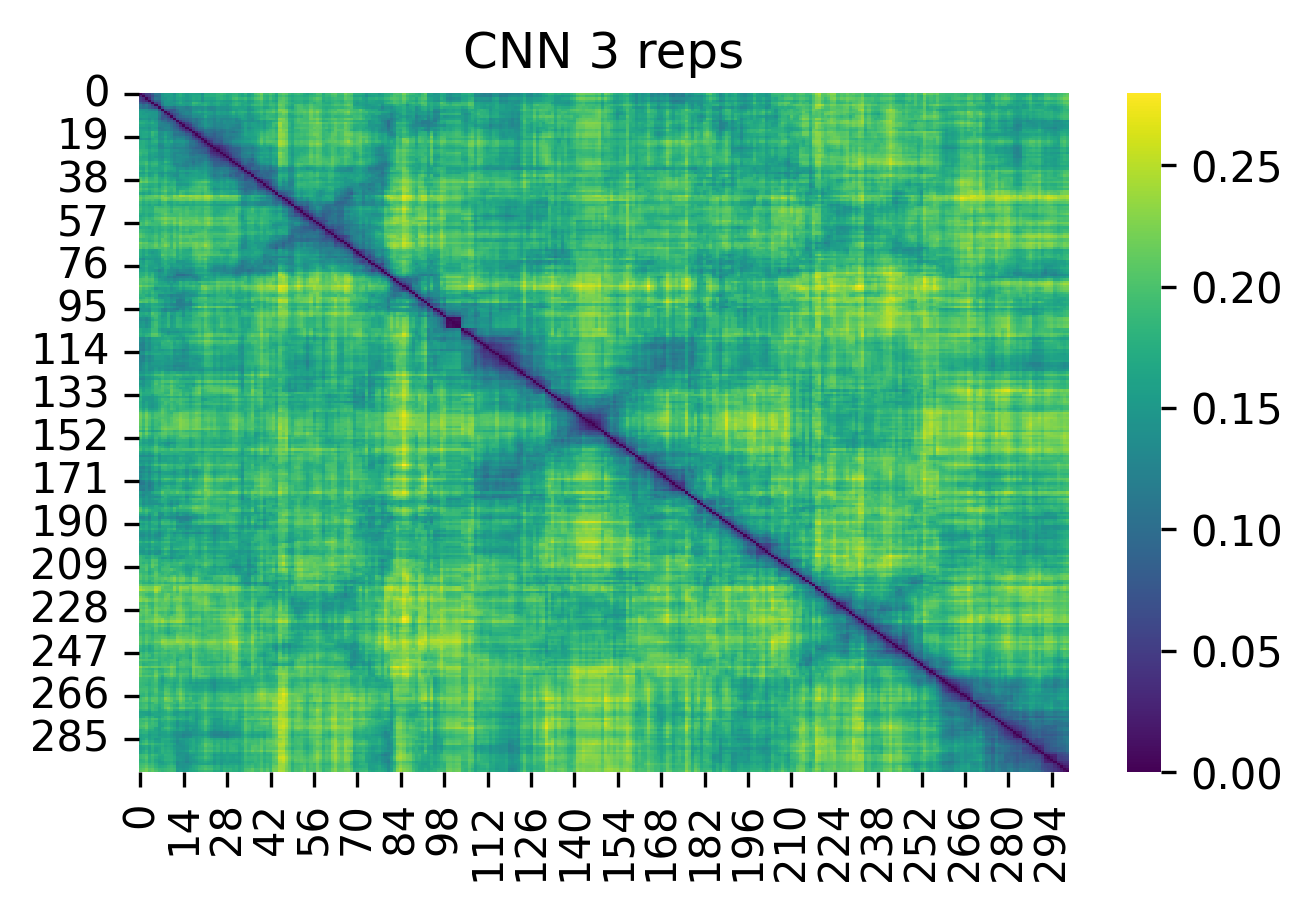

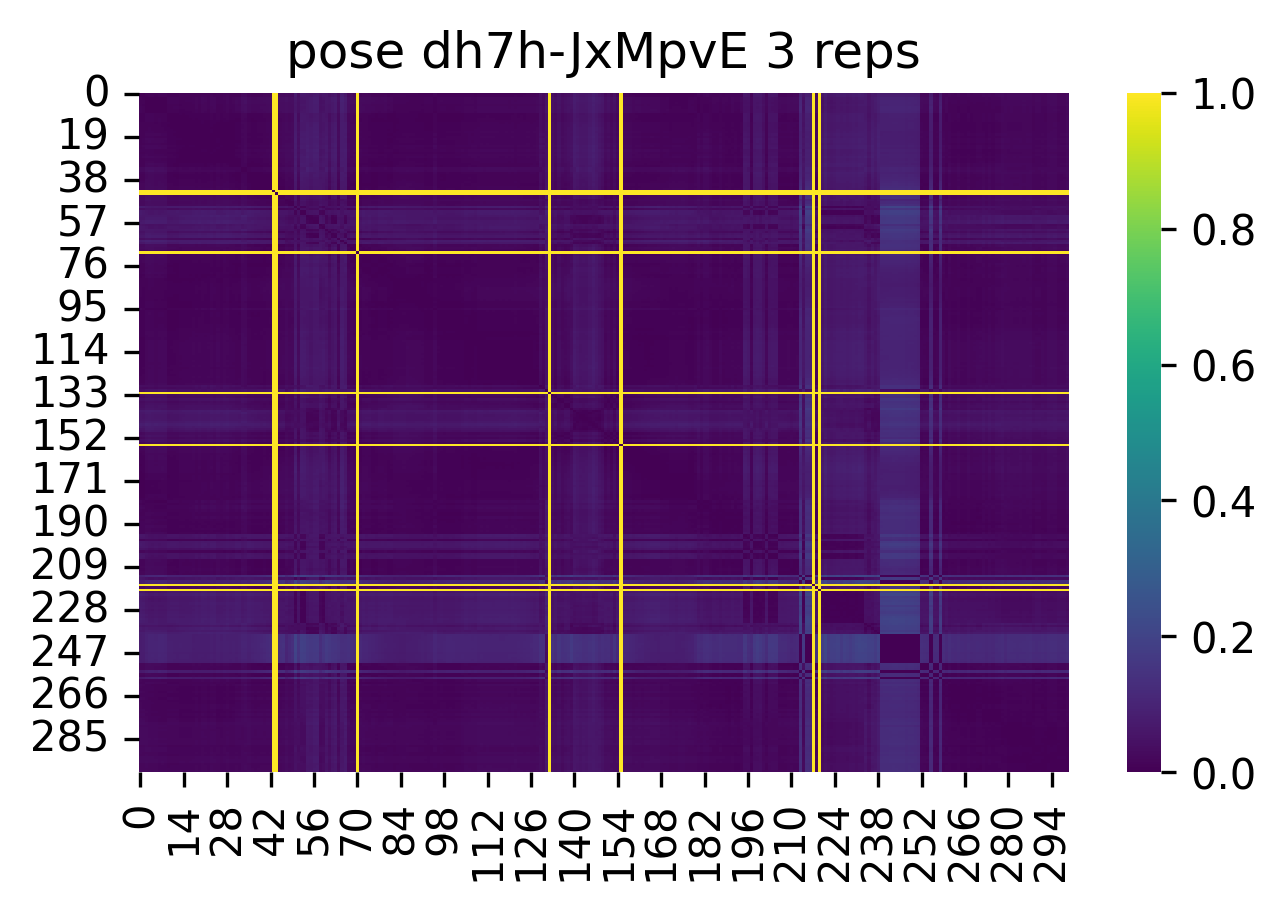

In [131]:
show_sim(feats, countix_anno['count'])
plot_pose_heatmap(countix_anno)